# Pong RL with Handcrafted Features

**Same CEM + LFA approach, but using handcrafted features instead of raw pixels**

This version extracts meaningful game information (ball position, paddle positions, etc.) instead of using raw pixel values.


## Cell 1: Setup - Find ROM Files

**What this does:** Finds the Pong ROM file needed to run the game.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ale_py import ALEInterface

plt.rcParams["figure.dpi"] = 120

# find ROM dir (set ALE_ROM_DIR if you want a specific path)
if "ALE_ROM_DIR" in os.environ and os.path.exists(os.environ["ALE_ROM_DIR"]):
    ROM_DIR = os.environ["ALE_ROM_DIR"]
else:
    # fallbacks
    try:
        import AutoROM, pathlib
        ROM_DIR = str(pathlib.Path(AutoROM.__file__).parent / "roms")
    except Exception:
        ROM_DIR = os.path.join(os.environ.get("CONDA_PREFIX", ""), "roms")

ROM_PATH = os.path.join(ROM_DIR, "pong.bin")
print("ROM_DIR:", ROM_DIR)
print("pong.bin exists:", os.path.exists(ROM_PATH))
assert os.path.exists(ROM_PATH), "pong.bin not found — set ALE_ROM_DIR correctly."


ROM_DIR: /Users/vicenteaguayo/Desktop/170/Pong_Team3/venv/lib/python3.11/site-packages/AutoROM/roms
pong.bin exists: True


## Cell 2: Initialize Game Environment

**What this does:** Sets up the Pong game environment with ALE (Arcade Learning Environment).


In [2]:
seed = 0
frameskip = 4  # 4 = faster training; 1 = slower but smoother

ale = ALEInterface()
ale.setInt("random_seed", seed)
ale.setBool("color_averaging", True)
ale.setInt("frame_skip", frameskip)
ale.setFloat("repeat_action_probability", 0.0)
ale.setBool("display_screen", False)
ale.setBool("sound", False)
ale.loadROM(ROM_PATH)

actions = ale.getMinimalActionSet()   # use minimal action set (smaller, easier)
shape = ale.getScreenGrayscale().shape
# Convert to Python ints (numpy .shape returns numpy scalars)
H = int(shape[0].item() if hasattr(shape[0], 'item') else shape[0])
W = int(shape[1].item() if hasattr(shape[1], 'item') else shape[1])

print("Minimal actions:", len(actions))
print("Gray shape (H,W):", (H, W))
print("H type:", type(H), "W type:", type(W))  # Debug: verify they're Python ints


Minimal actions: 6
Gray shape (H,W): (210, 160)
H type: <class 'int'> W type: <class 'int'>


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
Game console created:
  ROM file:  /Users/vicenteaguayo/Desktop/170/Pong_Team3/venv/lib/python3.11/site-packages/AutoROM/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 0


## Cell 3: Handcrafted Feature Extraction Functions

**What this does:** Defines functions to extract meaningful game features (ball position, paddle positions, etc.) instead of using raw pixels.

**Key difference from pixel version:** Instead of 2,689 pixel values, we extract ~12 meaningful features.


In [3]:
def find_paddle(region):
    """Find paddle position in a vertical region (left or right edge of screen)"""
    # Paddle is usually a bright vertical line
    # Sum horizontally to find vertical position
    col_sums = region.sum(axis=1)
    if col_sums.max() > 0:
        return int(np.argmax(col_sums))
    return region.shape[0] // 2  # Default to middle if not found

def find_ball(g_now, g_prev):
    """Find ball position by looking for moving bright objects"""
    if g_prev is None:
        return None, None, 0.0
    
    # Find moving objects (difference between frames)
    diff = np.abs(g_now.astype(float) - g_prev.astype(float))
    
    # Ball is usually the brightest moving object
    if diff.max() > 10:  # Threshold for movement
        idx = np.argmax(diff)
        ball_y, ball_x = np.unravel_index(idx, diff.shape)
        # Convert numpy scalars to Python ints using .item()
        return int(ball_y.item()), int(ball_x.item()), float(diff.max())
    
    return None, None, 0.0

def extract_handcrafted_features(g_now, g_prev, H, W):
    """
    Extract meaningful game features instead of raw pixels.
    
    Returns: feature vector of ~16 dimensions (vs 2,689 for pixels!)
    Includes: ball position, paddle positions, velocities, predicted ball position,
              distances, and timing features to help the model learn better strategies.
    """
    features = []
    
    # Convert H and W to Python ints (handle all possible types)
    # This ensures they work with numpy operations
    if isinstance(H, np.ndarray):
        H = int(H.flat[0])  # Get first element from array
    elif hasattr(H, 'item'):
        H = int(H.item())  # numpy scalar
    else:
        H = int(H)  # Already a Python int/float
    
    if isinstance(W, np.ndarray):
        W = int(W.flat[0])  # Get first element from array
    elif hasattr(W, 'item'):
        W = int(W.item())  # numpy scalar
    else:
        W = int(W)  # Already a Python int/float
    
    # Safety check: H and W should be positive
    if H <= 0 or W <= 0:
        raise ValueError(f"Invalid screen dimensions: H={H}, W={W}. Make sure Cell 4 was run to set up H and W.")
    
    # Find ball position
    ball_y, ball_x, ball_movement = find_ball(g_now, g_prev)
    if ball_y is None:
        # No ball found, use defaults
        ball_y = H // 2
        ball_x = W // 2
        ball_movement = 0.0
    else:
        # Already converted to Python ints in find_ball, but ensure they're ints
        ball_x = int(ball_x)
        ball_y = int(ball_y)
    
    # Normalize ball position (0 to 1)
    features.append(float(ball_x) / W)  # Ball X position
    features.append(float(ball_y) / H)  # Ball Y position
    
    # Find paddles (assume you're on right, opponent on left)
    left_region = g_now[:, :15]  # Left edge
    right_region = g_now[:, -15:]  # Right edge
    
    opponent_paddle_y = find_paddle(left_region)
    my_paddle_y = find_paddle(right_region)
    
    # Normalize paddle positions
    features.append(float(my_paddle_y) / H)  # My paddle Y position
    features.append(float(opponent_paddle_y) / H)  # Opponent paddle Y position
    
    # Ball-paddle distances (important for decision making)
    features.append(float(ball_y - my_paddle_y) / H)  # Distance to my paddle
    features.append(float(ball_y - opponent_paddle_y) / H)  # Distance to opponent paddle
    
    # Ball velocity (if we have previous frame)
    if g_prev is not None:
        prev_ball_y, prev_ball_x, _ = find_ball(g_prev, None)
        if prev_ball_y is not None:
            vel_y = float(ball_y - prev_ball_y) / H
            vel_x = float(ball_x - prev_ball_x) / W
        else:
            vel_y, vel_x = 0.0, 0.0
    else:
        vel_y, vel_x = 0.0, 0.0
    
    features.append(vel_x)  # Ball X velocity
    features.append(vel_y)  # Ball Y velocity
    
    # Ball speed magnitude (how fast is ball moving?)
    ball_speed = np.sqrt(vel_x**2 + vel_y**2 + 1e-6)
    features.append(float(ball_speed))
    
    # Distance to ball (Euclidean distance from my paddle to ball)
    dist_to_ball = np.sqrt((ball_x - W)**2 + (ball_y - my_paddle_y)**2 + 1e-6)
    features.append(float(dist_to_ball) / np.sqrt(H**2 + W**2))  # Normalized
    
    # Predicted ball Y position when it reaches my paddle (if ball coming toward me)
    if vel_x > 0.001:  # Ball coming toward right side (me)
        time_to_paddle = (W - ball_x) / (vel_x * W + 1e-6)
        predicted_y = ball_y + vel_y * H * time_to_paddle
        # Handle wall bounces (ball bounces off top/bottom)
        while predicted_y < 0 or predicted_y >= H:
            if predicted_y < 0:
                predicted_y = -predicted_y
                vel_y = -vel_y
            elif predicted_y >= H:
                predicted_y = 2*H - predicted_y
                vel_y = -vel_y
        features.append(float(predicted_y) / H)  # Normalized predicted position
        features.append(float(predicted_y - my_paddle_y) / H)  # Error: how far off am I?
    else:
        features.append(0.5)  # Default if ball not coming toward me
        features.append(0.0)  # No error if ball not coming
    
    # Ball movement magnitude
    features.append(float(ball_movement) / 255.0)
    
    # Which side is ball on? (1 = right side, -1 = left side)
    features.append(1.0 if ball_x > W // 2 else -1.0)
    
    # Is ball close to my paddle? (helps with timing)
    features.append(1.0 if abs(ball_x - W) < W * 0.2 else 0.0)
    
    # Bias term (always 1.0, helps the linear model)
    features.append(1.0)
    
    return np.array(features, dtype=np.float32)

print("Feature extraction functions defined!")


Feature extraction functions defined!


## Cell 4: Initialize CEM + LFA with Handcrafted Features

**What this does:** 
- Sets up CEM (Cross-Entropy Method) parameters
- Initializes weights for LFA (Linear Function Approximation)
- Tests a random episode to make sure everything works

**Key difference:** `feat_dim` is now ~12 instead of 2,689!


In [4]:
# Test feature extraction to get the dimension
g_test = np.empty((H, W), dtype=np.uint8)
ale.getScreenGrayscale(g_test)
phi_test = extract_handcrafted_features(g_test, None, H, W)
feat_dim = len(phi_test)  # This will be ~12 instead of 2,689!

n_actions = len(actions)

# CEM initialization
rng = np.random.default_rng(42)
W_mean = np.zeros((n_actions, feat_dim), dtype=np.float32)   # mean weights
W_std  = np.full((n_actions, feat_dim), 0.20, dtype=np.float32)  # std for sampling

best_score = -1e9  # best score so far
W_best = W_mean.copy() 

print("feat_dim:", feat_dim, "| n_actions:", n_actions)
print("(Compare: pixel version had feat_dim = 2,689)")

# Reset game to starting state
for _ in range(8):
    ale.act(actions[1 if len(actions)>1 else 0])
    if not ale.game_over():
        break

g_now = np.empty((H, W), dtype=np.uint8)
g_prev = None

# Sample a random policy to test
# NOTE: Using W_policy instead of W to avoid conflict with screen width W
W_policy = rng.normal(W_mean, W_std).astype(np.float32)

total = 0.0
steps = 0
max_steps = 20000

# Run one episode with random policy (baseline test)
while (not ale.game_over()) and steps < max_steps:
    ale.getScreenGrayscale(g_now)

    # KEY DIFFERENCE: Use handcrafted features instead of pixels!
    # Pass screen dimensions H and W (not the weight matrix!)
    phi = extract_handcrafted_features(g_now, g_prev, H, W)

    # Linear softmax policy (LFA part)
    z = W_policy @ phi
    z -= z.max()  # Numerical stability
    p = np.exp(z)
    p /= p.sum()
    a_idx = int(rng.choice(n_actions, p=p))
    a = actions[a_idx]

    r = ale.act(a)
    total += r
    steps += 1
    g_prev = g_now.copy()

print("Baseline random episode — Return:", total, "Steps:", steps)

# Reset for training
ale.reset_game()
g_prev = None
for _ in range(8):
    if (len(actions) > 1):
        ale.act(actions[1])
    else:
        ale.act(actions[0])


feat_dim: 16 | n_actions: 6
(Compare: pixel version had feat_dim = 2,689)
Baseline random episode — Return: -20.0 Steps: 897


## Cell 5: CEM Training - First Generation

**What this does:** Runs the first generation of CEM training.
- Samples 40 different policies (weights)
- Evaluates each by playing Pong
- Selects top 20% (elite policies)
- Updates the weight distribution based on elites


[Gen 1] elite_mean=-19.52 | best=-19.52 | std_mean=0.2434 | mean_steps=873 | cum_steps=87257


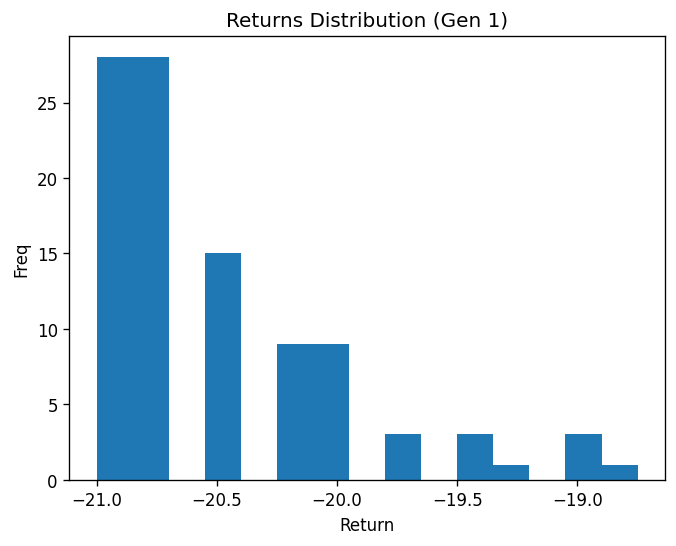

In [5]:
# Initialize history tracking
hist_iter = []
hist_elite_mean = []
hist_best = []
hist_std_mean = []
hist_mean_steps = []
hist_cum_steps = []
last_pop_returns = []
hist_pop_mean = []

cum_steps = 0
gen = 0

# CEM hyperparameters
pop_size = 100  # Number of policies to test per generation (increased for more diversity)
elite_frac = 0.15  # Top 20% become elites (standard CEM setting)
min_std = 0.05  # Minimum std to prevent collapse (increased to maintain exploration)
eval_episodes = 4  # Episodes per policy evaluation (increased for more stable evaluation)

gen += 1
pop_returns = []
pop_steps = []

# Sample population of policies
Ws = rng.normal(W_mean, W_std, size=(pop_size, n_actions, feat_dim)).astype(np.float32)

# Evaluate each policy in the population
for i in range(pop_size):
    scores = []
    steps_list = []
    for k in range(eval_episodes):
        # Reset game for new episode
        ale.reset_game()
        g_prev = None
        for _ in range(8):
            if (len(actions) > 1):
                ale.act(actions[1])
            else:
                ale.act(actions[0])

        total = 0.0
        steps = 0
        while (not ale.game_over()) and steps < max_steps:
            ale.getScreenGrayscale(g_now)

            # Extract handcrafted features
            phi = extract_handcrafted_features(g_now, g_prev, H, W)

            # Linear policy (LFA)
            z = Ws[i] @ phi
            z -= z.max()
            p = np.exp(z)
            p /= p.sum()
            a_idx = int(rng.choice(n_actions, p=p))
            r = ale.act(actions[a_idx])

            total += r
            steps += 1
            g_prev = g_now.copy()

        scores.append(total)
        steps_list.append(steps)
    pop_returns.append(np.mean(scores))
    mean_s = int(np.mean(steps_list))
    pop_steps.append(mean_s)
    cum_steps += mean_s

# Process results
pop_returns = np.array(pop_returns)
pop_steps = np.array(pop_steps)

pop_mean = float(pop_returns.mean())

# Select elite policies (top 20%)
k = max(1, int(elite_frac * pop_size))
elite_idx = np.argsort(pop_returns)[-k:]
elites = Ws[elite_idx]

# Update distribution based on elites (CEM update)
W_mean = elites.mean(axis=0)
W_std  = elites.std(axis=0) + min_std

elite_mean = float(pop_returns[elite_idx].mean())
std_mean = float(W_std.mean())
if elite_mean > best_score:
    best_score = elite_mean
    W_best = W_mean.copy()

# Log metrics
hist_iter.append(gen)
hist_elite_mean.append(elite_mean)
hist_best.append(best_score)
hist_std_mean.append(std_mean)
hist_mean_steps.append(float(pop_steps.mean()))
hist_cum_steps.append(cum_steps)
last_pop_returns = pop_returns.tolist()
hist_pop_mean.append(pop_mean)

print(f"[Gen {gen}] elite_mean={elite_mean:.2f} | best={best_score:.2f} | "
      f"std_mean={std_mean:.4f} | mean_steps={pop_steps.mean():.0f} | cum_steps={cum_steps}")

# Plot distribution of returns for this generation
plt.figure()
plt.title(f"Returns Distribution (Gen {gen})")
plt.hist(pop_returns, bins=15)
plt.xlabel("Return"); plt.ylabel("Freq")
plt.show()


## Cell 6: Plot Training Progress

**What this does:** Visualizes how training is going - returns, episode lengths, etc.


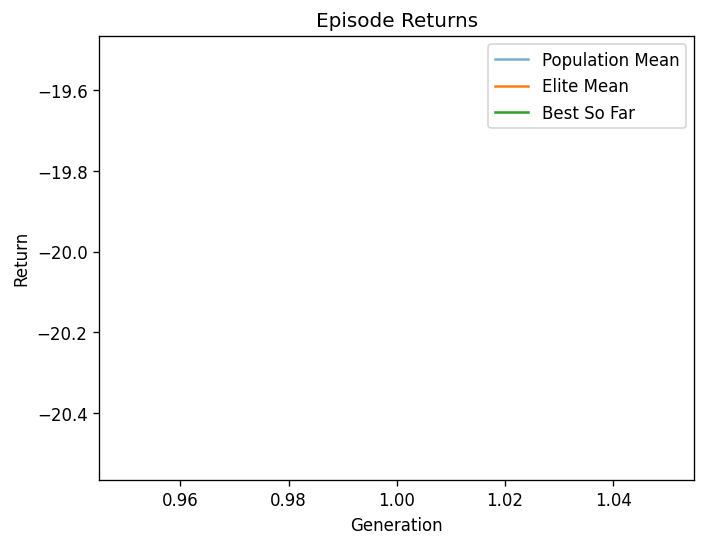

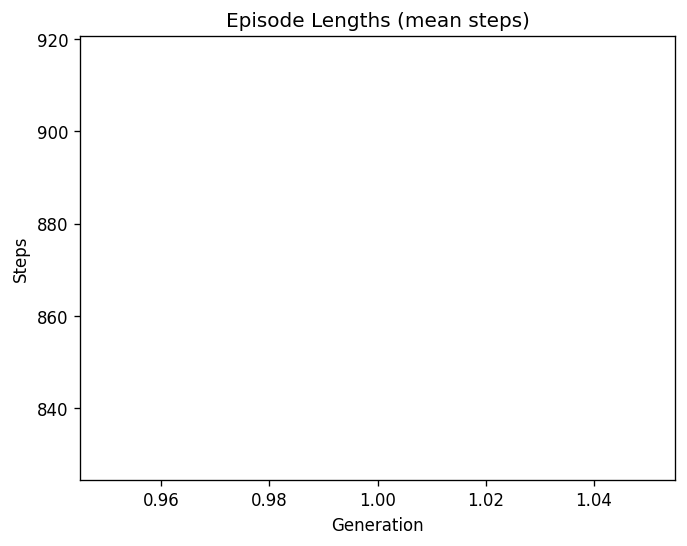

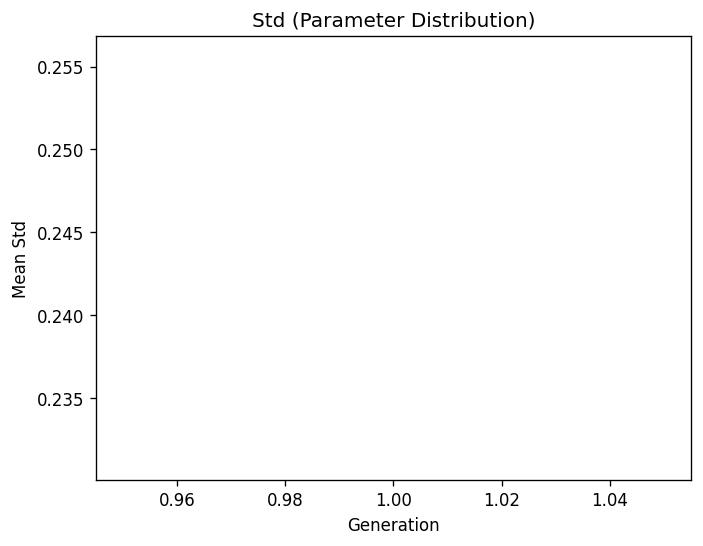

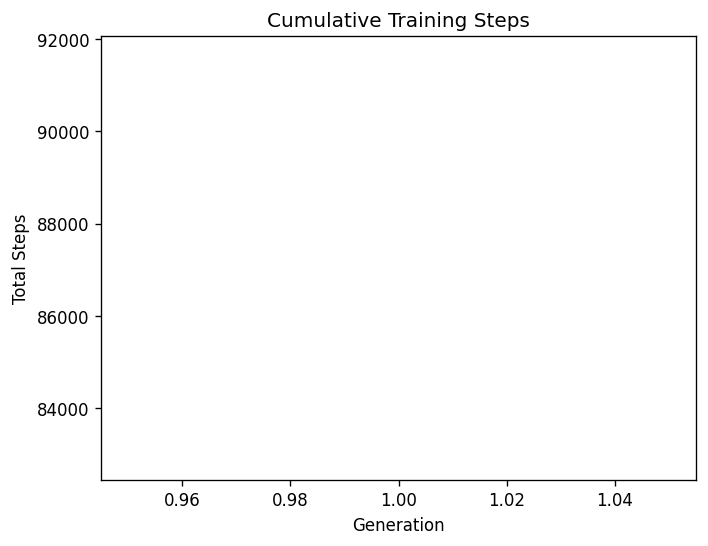

In [6]:
if len(hist_iter) == 0:
    print("no data yet")
else:
    x = np.array(hist_iter)

    # Check if we have population mean data
    have_pop = 'hist_pop_mean' in globals() and len(hist_pop_mean) == len(hist_iter)
    
    if have_pop:
        y_base = np.array(hist_pop_mean)
        base_label = "Population Mean"
    else:
        y_base = np.array(hist_elite_mean)
        base_label = "Elite Mean"

    # Episode Returns 
    plt.figure()
    plt.title("Episode Returns")
    if have_pop:
        plt.plot(x, hist_pop_mean, label="Population Mean", alpha=0.6)
    plt.plot(hist_iter, hist_elite_mean, label="Elite Mean")
    plt.plot(hist_iter, hist_best, label="Best So Far")
    plt.xlabel("Generation"); plt.ylabel("Return"); plt.legend(); plt.show()

    # Episode lengths
    plt.figure()
    plt.title("Episode Lengths (mean steps)")
    plt.plot(hist_iter, hist_mean_steps)
    plt.xlabel("Generation"); plt.ylabel("Steps"); plt.show()

    # Std (shows how much the policy distribution is changing)
    plt.figure()
    plt.title("Std (Parameter Distribution)")
    plt.plot(hist_iter, hist_std_mean)
    plt.xlabel("Generation"); plt.ylabel("Mean Std"); plt.show()

    # Cumulative steps
    plt.figure()
    plt.title("Cumulative Training Steps")
    plt.plot(hist_iter, hist_cum_steps)
    plt.xlabel("Generation"); plt.ylabel("Total Steps"); plt.show()


## Cell 7: Load Previous Checkpoint (Optional)

**What this does:** Loads previously saved weights and state so you can continue training from where you left off.

**Use this if:** You restarted the kernel or want to resume training from a saved checkpoint.


In [22]:
import os, json

# Check if checkpoints exist
if os.path.exists("checkpoints/state.json"):
    print("Found checkpoint! Loading...")
    
    # Load state
    with open("checkpoints/state.json", "r") as f:
        state_dict = json.load(f)
    
    # Load weights
    W_mean = np.load("checkpoints/W_mean.npy")
    W_std = np.load("checkpoints/W_std.npy")
    if os.path.exists("checkpoints/W_best.npy"):
        W_best = np.load("checkpoints/W_best.npy")
    else:
        W_best = W_mean.copy()
    
    # Load history
    if os.path.exists("checkpoints/history.json"):
        with open("checkpoints/history.json", "r") as f:
            hist = json.load(f)
        hist_iter = hist.get("iter", [])
        hist_elite_mean = hist.get("elite_mean", [])
        hist_best = hist.get("best_so_far", [])
        hist_std_mean = hist.get("std_mean", [])
        hist_mean_steps = hist.get("mean_steps", [])
        hist_cum_steps = hist.get("cum_steps", [])
        if "pop_mean" in hist:
            hist_pop_mean = hist["pop_mean"]
    else:
        # Initialize empty history
        hist_iter = []
        hist_elite_mean = []
        hist_best = []
        hist_std_mean = []
        hist_mean_steps = []
        hist_cum_steps = []
        hist_pop_mean = []
    
    # Restore state
    gen = state_dict.get("gen", 0)
    cum_steps = state_dict.get("cum_steps", 0)
    best_score = state_dict.get("best_score", -1e9)
    feat_dim = state_dict.get("feat_dim", len(phi_test) if 'phi_test' in globals() else 11)
    n_actions = state_dict.get("n_actions", len(actions) if 'actions' in globals() else 6)
    
    print(f"✓ Loaded checkpoint from generation {gen}")
    print(f"  Best score: {best_score:.2f}")
    print(f"  Cumulative steps: {cum_steps}")
    print(f"  History: {len(hist_iter)} generations")
else:
    print("No checkpoint found. Starting fresh.")
    print("(Run Cell 8 to save checkpoints after training)")


Found checkpoint! Loading...
✓ Loaded checkpoint from generation 59
  Best score: -17.94
  Cumulative steps: 4395407
  History: 57 generations


## Cell 8: Continue Training for More Generations

**What this does:** Runs more generations of CEM training. Change `N` to train for more/less generations.


In [7]:
N = 100  # Number of generations to train
save_every = 20  # Auto-save checkpoint every N generations (set to 0 to disable)

for _ in range(N):
    gen += 1
    pop_returns = []
    pop_steps = []
    # Sample new population from current distribution
    Ws = rng.normal(W_mean, W_std, size=(pop_size, n_actions, feat_dim)).astype(np.float32)

    # Evaluate each policy
    for i in range(pop_size):
        scores = []
        steps_list = []
        for k in range(eval_episodes):
            ale.reset_game()
            g_prev = None
            for _ in range(8): 
                ale.act(actions[1 if len(actions)>1 else 0])

            total = 0.0
            steps = 0
            while (not ale.game_over()) and steps < max_steps:
                ale.getScreenGrayscale(g_now)

                # Extract handcrafted features
                phi = extract_handcrafted_features(g_now, g_prev, H, W)

                # Linear policy
                z = Ws[i] @ phi
                z -= z.max()
                p = np.exp(z)
                p /= p.sum()
                a_idx = int(rng.choice(n_actions, p=p))
                r = ale.act(actions[a_idx])

                total += r
                steps += 1
                g_prev = g_now.copy()

            scores.append(total)
            steps_list.append(steps)
        pop_returns.append(np.mean(scores))
        mean_s = int(np.mean(steps_list))
        pop_steps.append(mean_s)
        cum_steps += mean_s

    pop_returns = np.array(pop_returns)
    pop_steps = np.array(pop_steps)

    # Select elites and update distribution
    k = max(1, int(elite_frac * pop_size))
    elite_idx = np.argsort(pop_returns)[-k:]
    elites = Ws[elite_idx]

    W_mean = elites.mean(axis=0)
    W_std  = elites.std(axis=0) + min_std

    elite_mean = float(pop_returns[elite_idx].mean())
    std_mean = float(W_std.mean())
    if elite_mean > best_score:
        best_score = elite_mean
        W_best = W_mean.copy()

    # Log metrics
    hist_iter.append(gen)
    hist_elite_mean.append(elite_mean)
    hist_best.append(best_score)
    hist_std_mean.append(std_mean)
    hist_mean_steps.append(float(pop_steps.mean()))
    hist_cum_steps.append(cum_steps)
    last_pop_returns = pop_returns.tolist()
    hist_pop_mean.append(pop_mean)

    print(f"[Gen {gen}] elite_mean={elite_mean:.2f} | best={best_score:.2f} | "
          f"std_mean={std_mean:.4f} | mean_steps={pop_steps.mean():.0f} | cum_steps={cum_steps}")
    
    # Auto-save checkpoint every N generations
    if save_every > 0 and gen % save_every == 0:
        import os, json
        os.makedirs("checkpoints", exist_ok=True)
        
        # Save weights
        if 'W_best' in globals():
            np.save("checkpoints/W_best.npy", W_best)
        else:
            np.save("checkpoints/W_best.npy", W_mean)
        np.save("checkpoints/W_mean.npy", W_mean)
        np.save("checkpoints/W_std.npy", W_std)
        
        # Save state
        state_dict = {
            "gen": int(gen),
            "cum_steps": int(cum_steps),
            "best_score": float(best_score),
            "feat_dim": int(feat_dim),
            "n_actions": int(n_actions),
            "frameskip": int(frameskip),
            "max_steps": int(max_steps),
        }
        with open("checkpoints/state.json", "w") as f:
            json.dump(state_dict, f, indent=2)
        
        # Save training history
        hist = {
            "iter": hist_iter,
            "elite_mean": hist_elite_mean,
            "best_so_far": hist_best,
            "std_mean": hist_std_mean,
            "mean_steps": hist_mean_steps,
            "cum_steps": hist_cum_steps,
        }
        if 'hist_pop_mean' in globals(): 
            hist["pop_mean"] = hist_pop_mean
        with open("checkpoints/history.json", "w") as f:
            json.dump(hist, f)
        
        print(f"  ✓ Auto-saved checkpoint at generation {gen}")


[Gen 2] elite_mean=-19.68 | best=-19.52 | std_mean=0.2744 | mean_steps=868 | cum_steps=174022
[Gen 3] elite_mean=-19.28 | best=-19.28 | std_mean=0.3138 | mean_steps=888 | cum_steps=262839
[Gen 4] elite_mean=-19.40 | best=-19.28 | std_mean=0.3522 | mean_steps=883 | cum_steps=351169
[Gen 5] elite_mean=-19.20 | best=-19.20 | std_mean=0.3738 | mean_steps=890 | cum_steps=440124
[Gen 6] elite_mean=-19.22 | best=-19.20 | std_mean=0.4029 | mean_steps=891 | cum_steps=529269


KeyboardInterrupt: 

## Cell 9: Clear History (Optional)

**What this does:** Clears all training history from memory.

**Use this when:** You're changing hyperparams and want to start with a fresh history for comparison.

**Skip this when:** You're continuing training with the same hyperparams and want to accumulate history.


In [ ]:
# Clear all training history
hist_iter = []
hist_elite_mean = []
hist_best = []
hist_std_mean = []
hist_mean_steps = []
hist_cum_steps = []
hist_pop_mean = []

print("✓ History cleared. Starting fresh.")


## Cell 10: Save Checkpoint

**What this does:** Saves the trained weights and training history to files.


In [24]:
import os, json
os.makedirs("checkpoints", exist_ok=True)

# Save weights
if 'W_best' in globals():
    np.save("checkpoints/W_best.npy", W_best)
else:
    np.save("checkpoints/W_best.npy", W_mean)

np.save("checkpoints/W_mean.npy", W_mean)
np.save("checkpoints/W_std.npy",  W_std)

# Save state
state_dict = {
    "gen": int(gen),
    "cum_steps": int(cum_steps),
    "best_score": float(best_score),
    "feat_dim": int(feat_dim),
    "n_actions": int(n_actions),
    "frameskip": int(frameskip),
    "max_steps": int(max_steps),
}
with open("checkpoints/state.json", "w") as f:
    json.dump(state_dict, f, indent=2)

# Save training history
hist = {
    "iter": hist_iter,
    "elite_mean": hist_elite_mean,
    "best_so_far": hist_best,
    "std_mean": hist_std_mean,
    "mean_steps": hist_mean_steps,
    "cum_steps": hist_cum_steps,
}
if 'hist_pop_mean' in globals(): 
    hist["pop_mean"] = hist_pop_mean
with open("checkpoints/history.json", "w") as f:
    json.dump(hist, f)

print("✔ Saved snapshot to ./checkpoints/")


✔ Saved snapshot to ./checkpoints/


## Cell 11: Save Experiment Run (Manual)

**What this does:** Saves a complete experiment snapshot for your report.
- Takes a screenshot of the current training plot
- Saves hyperparameters used
- Saves model weights
- Records generation count and performance metrics
- Creates a timestamped folder so you can compare different runs

**When to use:** Run this manually when you want to save a "good run" or compare different hyperparameter settings.


In [ ]:
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Create experiments directory
os.makedirs("experiments", exist_ok=True)

# Generate timestamp for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = f"experiments/run_{timestamp}"
os.makedirs(exp_dir, exist_ok=True)

# 1. Save screenshot of current training plot
if len(hist_iter) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Elite mean and best score over time
    axes[0, 0].plot(hist_iter, hist_elite_mean, label='Elite Mean', alpha=0.7)
    axes[0, 0].plot(hist_iter, hist_best, label='Best So Far', linewidth=2)
    axes[0, 0].set_xlabel('Generation')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].set_title('Training Progress')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Std mean (exploration)
    axes[0, 1].plot(hist_iter, hist_std_mean, color='green', alpha=0.7)
    axes[0, 1].set_xlabel('Generation')
    axes[0, 1].set_ylabel('Std Mean')
    axes[0, 1].set_title('Exploration (Std)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Mean steps per episode
    axes[1, 0].plot(hist_iter, hist_mean_steps, color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Generation')
    axes[1, 0].set_ylabel('Mean Steps')
    axes[1, 0].set_title('Episode Length')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Cumulative steps
    axes[1, 1].plot(hist_iter, hist_cum_steps, color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Generation')
    axes[1, 1].set_ylabel('Cumulative Steps')
    axes[1, 1].set_title('Total Training Steps')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{exp_dir}/training_plot.png", dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved training plot to {exp_dir}/training_plot.png")
else:
    print("⚠ No training history to plot yet")

# 2. Save hyperparameters
hyperparams = {
    "pop_size": int(pop_size) if 'pop_size' in globals() else None,
    "elite_frac": float(elite_frac) if 'elite_frac' in globals() else None,
    "min_std": float(min_std) if 'min_std' in globals() else None,
    "eval_episodes": int(eval_episodes) if 'eval_episodes' in globals() else None,
    "frameskip": int(frameskip) if 'frameskip' in globals() else None,
    "max_steps": int(max_steps) if 'max_steps' in globals() else None,
    "feat_dim": int(feat_dim) if 'feat_dim' in globals() else None,
    "n_actions": int(n_actions) if 'n_actions' in globals() else None,
}

with open(f"{exp_dir}/hyperparameters.json", "w") as f:
    json.dump(hyperparams, f, indent=2)
print(f"✓ Saved hyperparameters to {exp_dir}/hyperparameters.json")

# 3. Save model weights
if 'W_best' in globals():
    np.save(f"{exp_dir}/W_best.npy", W_best)
    print(f"✓ Saved W_best to {exp_dir}/W_best.npy")
if 'W_mean' in globals():
    np.save(f"{exp_dir}/W_mean.npy", W_mean)
    print(f"✓ Saved W_mean to {exp_dir}/W_mean.npy")
if 'W_std' in globals():
    np.save(f"{exp_dir}/W_std.npy", W_std)
    print(f"✓ Saved W_std to {exp_dir}/W_std.npy")

# 4. Save experiment summary (generations, performance, etc.)
summary = {
    "timestamp": timestamp,
    "total_generations": int(gen) if 'gen' in globals() else 0,
    "cumulative_steps": int(cum_steps) if 'cum_steps' in globals() else 0,
    "best_score": float(best_score) if 'best_score' in globals() else None,
    "current_elite_mean": float(hist_elite_mean[-1]) if len(hist_elite_mean) > 0 else None,
    "current_std_mean": float(hist_std_mean[-1]) if len(hist_std_mean) > 0 else None,
    "current_mean_steps": float(hist_mean_steps[-1]) if len(hist_mean_steps) > 0 else None,
    "hyperparameters": hyperparams,
    "feature_count": int(feat_dim) if 'feat_dim' in globals() else None,
}

# If loading from checkpoint, track that info too
if os.path.exists("checkpoints/state.json"):
    with open("checkpoints/state.json", "r") as f:
        checkpoint_state = json.load(f)
    summary["loaded_from_checkpoint"] = True
    summary["checkpoint_generation"] = checkpoint_state.get("gen", 0)
    summary["generations_this_run"] = int(gen) - checkpoint_state.get("gen", 0) if 'gen' in globals() else 0
else:
    summary["loaded_from_checkpoint"] = False
    summary["generations_this_run"] = int(gen) if 'gen' in globals() else 0

with open(f"{exp_dir}/summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print(f"✓ Saved experiment summary to {exp_dir}/summary.json")

# 5. Save full training history
if len(hist_iter) > 0:
    history = {
        "iter": hist_iter,
        "elite_mean": hist_elite_mean,
        "best_so_far": hist_best,
        "std_mean": hist_std_mean,
        "mean_steps": hist_mean_steps,
        "cum_steps": hist_cum_steps,
    }
    if 'hist_pop_mean' in globals():
        history["pop_mean"] = hist_pop_mean
    
    with open(f"{exp_dir}/history.json", "w") as f:
        json.dump(history, f, indent=2)
    print(f"✓ Saved full training history to {exp_dir}/history.json")

print(f"\n🎉 Experiment saved to: {exp_dir}/")
print(f"   - Training plot: training_plot.png")
print(f"   - Hyperparameters: hyperparameters.json")
print(f"   - Weights: W_best.npy, W_mean.npy, W_std.npy")
print(f"   - Summary: summary.json")
print(f"   - Full history: history.json")
